# Segmentación de datos clientes




El conjunto de datos Online Retail contiene información sobre transacciones de ventas como el número de factura, el código del producto, la cantidad vendida, la fecha de la transacción, el precio unitario, el identificador del cliente y el país de origen, con los cuales se busca generar una segmentación de clientes con las cuales se pueda identificar distintos patrones para la toma de decisiones empresariales.

Para abordar esta problemática, se usará el método K-means que comunmente es usadado en este tipo de tareas.

Para ello se dispondrá de las siguientes fases:

*1.   Entendimiento y limpieza de datos.* \\
*2.   Generación del modelo.* \\
*3.   Conclusiones y recomendaciones.* \\


---
---
# Fase 1:Entendimiento y limpieza de los datos

En primer lugar se obtiene el conjunto de datos sobre Online Retail, garantizando que todos los registros se carguen de manera correcta. Presentando un total de 541.909 observaciones y 8 variables.

### Descripción de las Variables del Dataset Online Retail.
A continuación se describen las características de cada variable usada para el análisis a realizar. También se identifican los tipos de datos y los valores faltantes para validar que no existan inconsistencias que afecten el modelo a implementar.

Se identifica una cantidad considerable de valores faltantes en la columna de "CustomerID", lo cual es importante tener en cuenta para llevar a cabo el análisis mediante el RFM.


| **Nombre de Variable** | **Descripción** |
|------------------------|----------------------------------------------------------------|
| InvoiceNo             | Número de cada transacción, la letra 'C' indica una cancelación. |
| StockCode             | Número entero de 5 dígitos asignado a cada producto único. |
| Description           | Nombre del producto. |
| Quantity             | Cantidad de cada producto por transacción. |
| InvoiceDate          | Día y hora en que se generó cada transacción. |
| UnitPrice           | Precio del producto por unidad. |
| CustomerID          | Identificación de cada cliente. |
| Country            | Nombre del país de residencia. |


In [ ]:
#--------------------
#tipo de variables y valores nulos del conjunto de datos.
#--------------------

import pandas as pd
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Cargar el dataset
url = 'https://archive.ics.uci.edu/static/public/352/data.csv'
df = pd.read_csv(url, encoding='ISO-8859-1')

# Extraer información del DataFrame
data_info = {
    "**Nombre de Variable**": df.columns,
    "**Tipo de Dato**": [df[col].dtype for col in df.columns],
    "**Valores Nulos**": [df[col].isnull().sum() for col in df.columns],
    "**Valores Únicos**": [df[col].nunique() for col in df.columns]
}

# Convertir en DataFrame
df_info = pd.DataFrame(data_info)

# Imprimir en formato tabla con Markdown
tabla = tabulate(df_info, headers="keys", tablefmt="pipe", showindex=False)
print(tabla)



| **Nombre de Variable**   | **Tipo de Dato**   |   **Valores Nulos** |   **Valores Únicos** |
|:-------------------------|:-------------------|--------------------:|---------------------:|
| InvoiceNo                | object             |                   0 |                25900 |
| StockCode                | object             |                   0 |                 4070 |
| Description              | object             |                1454 |                 4223 |
| Quantity                 | int64              |                   0 |                  722 |
| InvoiceDate              | object             |                   0 |                23260 |
| UnitPrice                | float64            |                   0 |                 1630 |
| CustomerID               | float64            |              135080 |                 4372 |
| Country                  | object             |                   0 |                   38 |


## Filtrado inicial.
Posteriormente, se filtran las variables que no son relevantes para el análisis, como lo son las transacciones canceladas (códigos de InvoiceNo que comienzan con 'C'), los precios menores o iguales a cero y las cantidades menores a cero.

Esto es fundamental para el análisis RFM  (Recency, Frequency, Monetary) [1] , ya que:

*  Recency (Recencia): Se basa en la fecha de la última compra, por lo que es
crucial eliminar transacciones canceladas.

* Frequency (Frecuencia): Se mide por el número de compras realizadas, por lo que las transacciones inválidas (cantidad negativa) afectarían el cálculo.

* Monetary (Monetario): Se basa en el valor total gastado por el cliente, por lo que precios no válidos (≤ 0) distorsionarían el análisis.

In [ ]:
#--------------------
# Filtrado de valores no validos para el análisis.
#--------------------

# Filtrar transacciones canceladas (códigos de InvoiceNo que comienzan con 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Filtrar valores de UnitPrice que son cero o menores
df = df[df['UnitPrice'] > 0]

# Filtrar valores de Quantity que son mayores a 0
df = df[df['Quantity'] > 0]

df_no_client = df.copy()
df_no_client = df_no_client[df_no_client['CustomerID'].isnull()]
df = df.dropna(subset=['CustomerID'])

df['CustomerID'] = df['CustomerID'].astype(str).str.replace('.0$', '', regex=True)

In [ ]:
print(df.describe())
#print(df_no_client.describe())

ratio = len(df_no_client) / (len(df)+len(df_no_client))
print(f"Porcentaje sin id: {ratio:.2f}")

            Quantity      UnitPrice
count  397884.000000  397884.000000
mean       12.988238       3.116488
std       179.331775      22.097877
min         1.000000       0.001000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max     80995.000000    8142.750000
Porcentaje sin id: 0.25


Luego de evaluar la base de datos, se identificaron que, aproximadamente, un 25% de los registros no tienen un `CustomerID` asignado. Por lo tanto, no habria forma de asignar dichas compras a un cliente. Teniendo en cuenta esto se dividió el conjunto de datos en dos: uno para realizar la segmentación mediante el RFM y el otro que contiene las compras anonimas, y que por tanto no se pueden usara para este análisis de esta manera.

## Boxplot variables numéricas

### Df con clientes

Mediente los boxplot de precios unitarios y cantidades, se pueden identificar ciertos valores atipicos que podrian corresponder a clientes mayoristas.

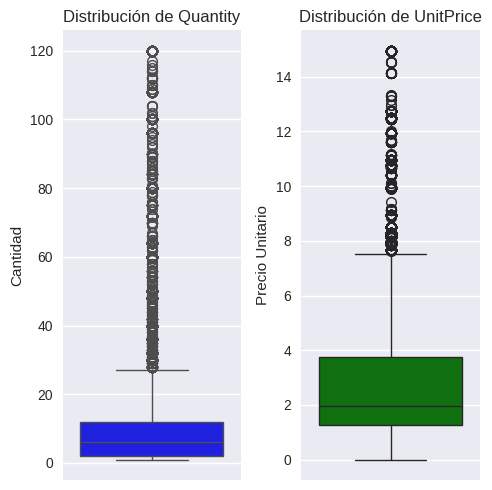

In [ ]:
#---------------------------------------------
#Boxplot precios y cantidades -clientes con ID
#----------------------------------------------

import seaborn as sns
import matplotlib.pyplot as plt

# Definir límites usando el percentil 99 para evitar valores extremos
quantity_limit = df["Quantity"].quantile(0.99)
unitprice_limit = df["UnitPrice"].quantile(0.99)

# Crear subplots en formato vertical
fig, axes = plt.subplots(1, 2, figsize=(5, 5))

# Boxplot para Quantity (sin valores extremos)
sns.boxplot(y=df["Quantity"].clip(upper=quantity_limit), ax=axes[0], color="blue")
axes[0].set_title("Distribución de Quantity")
axes[0].set_ylabel("Cantidad")

# Boxplot para UnitPrice (sin valores extremos)
sns.boxplot(y=df["UnitPrice"].clip(upper=unitprice_limit), ax=axes[1], color="green")
axes[1].set_title("Distribución de UnitPrice")
axes[1].set_ylabel("Precio Unitario")

plt.tight_layout()
plt.show()



## Df sin ID de clientes.

Al igual que en el caso anterior, se identifican transacciones de mayorista que no cuentan con ID del  cliente, lo cual es pertinente revisar a detalle.

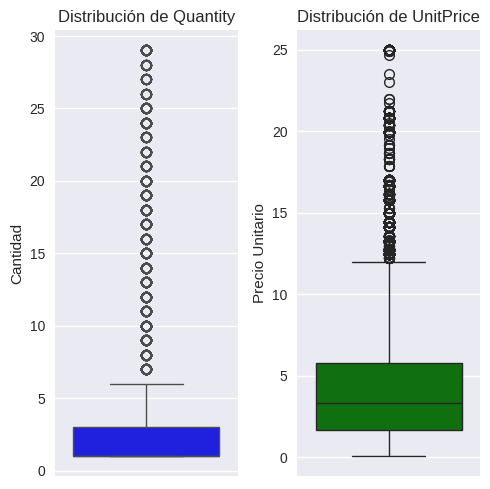

In [ ]:
#-------------------------------------------------
# Boxplot de cantidades y precios- clientes sin ID
#-------------------------------------------------

# Definir límites usando el percentil 99 para evitar valores extremos
noclient_quantity_limit = df_no_client["Quantity"].quantile(0.99)
noclient_unitprice_limit = df_no_client["UnitPrice"].quantile(0.99)

# Crear subplots en formato vertical
noclient_fig, noclient_axes = plt.subplots(1, 2, figsize=(5, 5))

# Boxplot para Quantity (sin valores extremos)
sns.boxplot(y=df_no_client["Quantity"].clip(upper=noclient_quantity_limit), ax=noclient_axes[0], color="blue")
noclient_axes[0].set_title("Distribución de Quantity")
noclient_axes[0].set_ylabel("Cantidad")

# Boxplot para UnitPrice (sin valores extremos)
sns.boxplot(y=df_no_client["UnitPrice"].clip(upper=noclient_unitprice_limit), ax=noclient_axes[1], color="green")
noclient_axes[1].set_title("Distribución de UnitPrice")
noclient_axes[1].set_ylabel("Precio Unitario")

plt.tight_layout()
plt.show()

## Top 10 países con mas ventas

### Df con clientes

Se identificó la distribución de los clientes por países, donde la mayoría de productos comprados se concentran principalmente en el Reino Unido, seguido de los Países Bajos, Irlanda y Alemania con un porcentaje mucho menor.

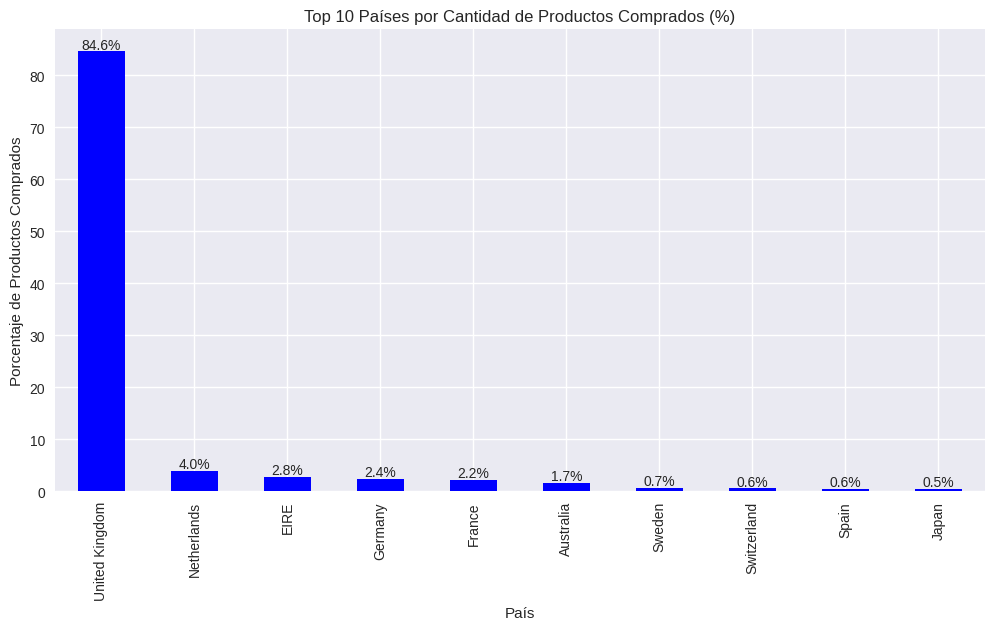

In [ ]:
#------------------------------------
# Top 10 Países -transacciones con ID
#------------------------------------

import matplotlib.pyplot as plt

# Calcular la cantidad total en porcentaje
country_quantity_pct = df.groupby("Country")["Quantity"].sum().sort_values(ascending=False).head(10)
country_quantity_pct = (country_quantity_pct / country_quantity_pct.sum()) * 100

# Crear la gráfica de barras
plt.figure(figsize=(12, 6))
country_quantity_pct.plot(kind="bar", color="blue")

# Etiquetas y título
plt.title("Top 10 Países por Cantidad de Productos Comprados (%)")
plt.xlabel("País")
plt.ylabel("Porcentaje de Productos Comprados")
plt.xticks(rotation=90)

# Mostrar valores en las barras
for i, pct in enumerate(country_quantity_pct):
    plt.text(i, pct + 0.5, f"{pct:.1f}%", ha="center", fontsize=10)

plt.show()

## Df sin ID de clientes

Se identificó la distribución de los países donde se realizan compran de que no cuentan con identificación de clientes, presentandose principalmenten en Reino Unido.

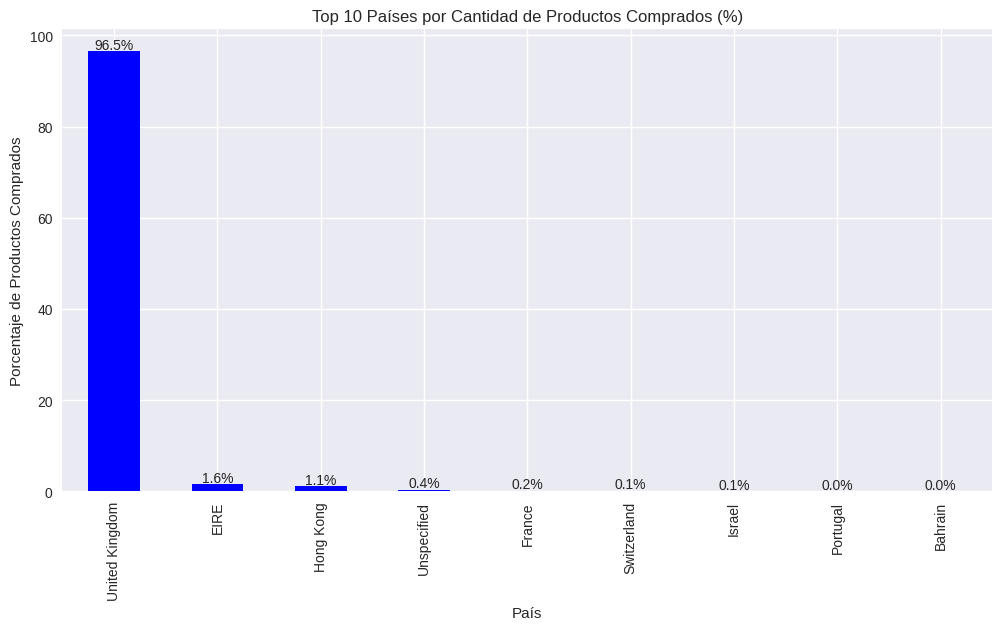

In [ ]:
#-----------------------------------
#Top 10 países, transacciones sin ID
#-----------------------------------

# Calcular la cantidad total en porcentaje
noclient_country_quantity_pct = df_no_client.groupby("Country")["Quantity"].sum().sort_values(ascending=False).head(10)
noclient_country_quantity_pct = (noclient_country_quantity_pct / noclient_country_quantity_pct.sum()) * 100

# Crear la gráfica de barras
plt.figure(figsize=(12, 6))
noclient_country_quantity_pct.plot(kind="bar", color="blue")

# Etiquetas y título
plt.title("Top 10 Países por Cantidad de Productos Comprados (%)")
plt.xlabel("País")
plt.ylabel("Porcentaje de Productos Comprados")
plt.xticks(rotation=90)

# Mostrar valores en las barras
for i, pct in enumerate(noclient_country_quantity_pct):
    plt.text(i, pct + 0.5, f"{pct:.1f}%", ha="center", fontsize=10)

plt.show()

## Histórico de ventas por mes

En este gráfico podemos notar una cantidad promedio aproximada de 330.000 productos durante el primer semestre del año. Y de ahí en adelante, las ventas empiezan de manera exponencial hasta Noviembre, llegando a más de 650.000. Para tener una caída de más del 50% de un mes a otro, cerrando el año con un valor incluso menor que con el que se inició.

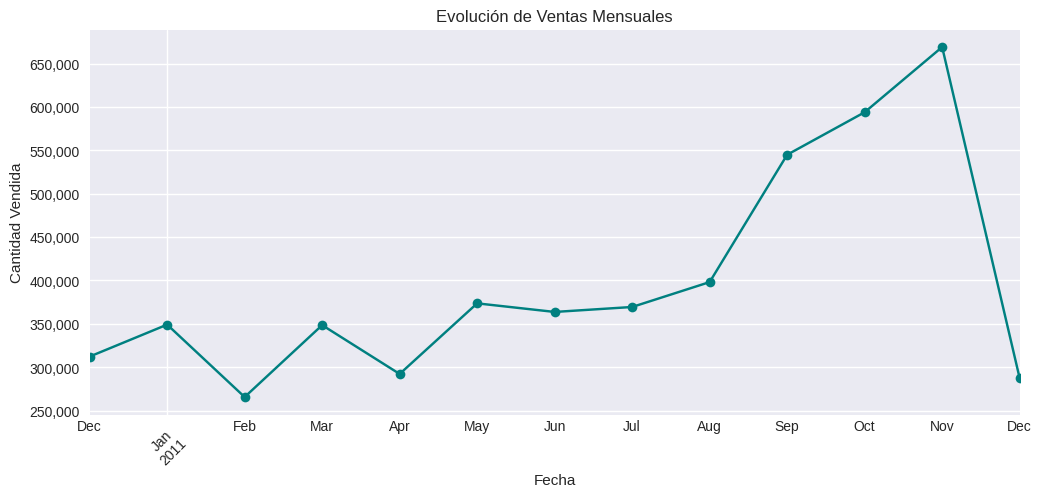

In [ ]:
#--------------------
#Histórico de ventas.
#--------------------

import matplotlib.ticker as mticker

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df["YearMonth"] = df["InvoiceDate"].dt.to_period("M")

# Agrupar por mes
ventas_mensuales = df.groupby("YearMonth")["Quantity"].sum()

# Graficar
plt.figure(figsize=(12, 5))
ax = ventas_mensuales.plot(marker="o", color="teal")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.title("Evolución de Ventas Mensuales")
plt.xlabel("Fecha")
plt.ylabel("Cantidad Vendida")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Top 10 de clientes con mas compras (Por cantidad de productos)
Se muestran los 10 clientes mas relevantes para la empresa, aunque es importante resaltar que podría existir clientes que esten incluidos en esta lista pero que por errores del sistema no cuentan con ID registrado. Dado la gran importancia que podrían tener, es relevante prestar atención a estos casos.

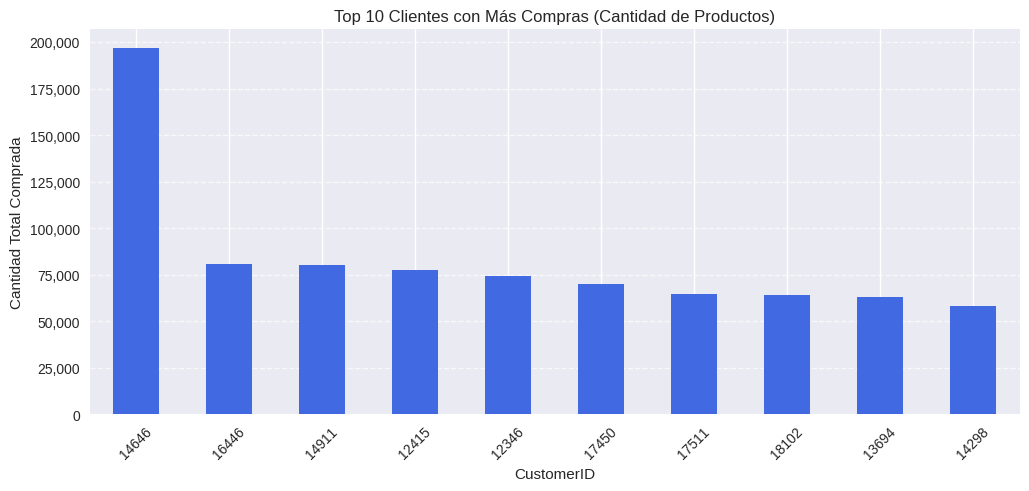

In [ ]:
#------------------
# Top 10 Clientes
#-----------------
clientes_top_cantidad = df.groupby("CustomerID")["Quantity"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 5))
ct = clientes_top_cantidad.plot(kind="bar", color="royalblue")
ct.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.title("Top 10 Clientes con Más Compras (Cantidad de Productos)")
plt.xlabel("CustomerID")
plt.ylabel("Cantidad Total Comprada")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## Diagrama de pareto de productos por clientes.

También se identificó que existe una alta concentración de las cantidades compradas por parte de los 4.338 clientes totales, pues el 80\% de esta cantidad se concentra en 1.008 clientes (25.6\% de los clientes totales).

Número de clientes que concentran el 80% de las compras: 1108
Total de clientes únicos: 4338


<ipython-input-55-89b7392e6051>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  crossing_y = clientes_cantidad_pct[crossing_index] * 100  # Convert to percentage


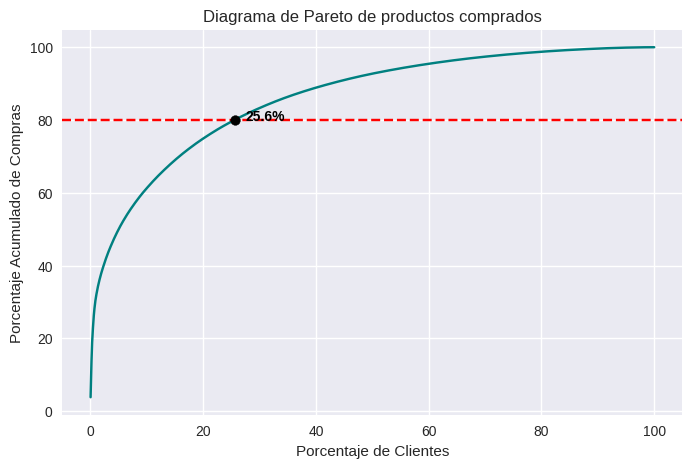

In [ ]:
#------------------------------------------------------------------------
#Gráfico de pareto, concentración de clientes.
#------------------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

# Agrupar por cliente y calcular la cantidad total comprada
clientes_cantidad = df.groupby("CustomerID")["Quantity"].sum().sort_values(ascending=False)

# Calcular el porcentaje acumulado
clientes_cantidad_pct = clientes_cantidad.cumsum() / clientes_cantidad.sum()

# Contar cuántos clientes concentran el 80% de las compras
clientes_80 = (clientes_cantidad_pct <= 0.80).sum()

# Total de clientes únicos
total_clientes = df["CustomerID"].nunique()

print(f"Número de clientes que concentran el 80% de las compras: {clientes_80}")
print(f"Total de clientes únicos: {total_clientes}")

customer_pct = np.arange(1, len(clientes_cantidad_pct) + 1) / len(clientes_cantidad_pct)

crossing_index = np.argmax(clientes_cantidad_pct >= 0.80)  # First index where purchases reach 80%
crossing_x = customer_pct[crossing_index] * 100  # Convert to percentage
crossing_y = clientes_cantidad_pct[crossing_index] * 100  # Convert to percentage

# Curva de Lorenz
plt.figure(figsize=(8, 5))
plt.plot(customer_pct * 100, clientes_cantidad_pct * 100, label="Distribución de compras", color="teal")

# Marca al 80%
plt.scatter(crossing_x, crossing_y, color="black", zorder=3)
plt.text(crossing_x + 2, crossing_y, f"{crossing_x:.1f}%", fontsize=10, color="black", fontweight="bold")  # Annotate point
plt.axhline(y=80, color="red", linestyle="--")

# Etiquetas
plt.xlabel("Porcentaje de Clientes")
plt.ylabel("Porcentaje Acumulado de Compras")
plt.title("Diagrama de Pareto de productos comprados")
plt.grid(True)

plt.show()

## Top 10 clientes con más compras.

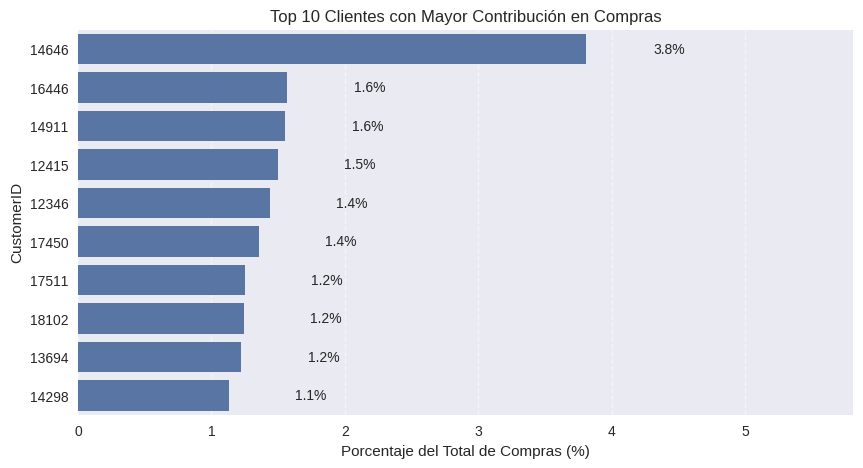

In [ ]:
#------------------------------------------------------------------------
#Top 10 mejores clientes.
#------------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Agrupar por cliente y calcular la cantidad total comprada
clientes_cantidad = df.groupby("CustomerID")["Quantity"].sum().sort_values(ascending=False)

# Seleccionar el top 10 de clientes
clientes_top10 = clientes_cantidad.head(10)  # Corregido: head(10) para el top 10

# Calcular el porcentaje sobre el total de compras (corregido)
total_cantidad = clientes_cantidad.sum()  # Obtener la cantidad total de todos los clientes
clientes_top10_pct = (clientes_top10 / total_cantidad) * 100

# Ordenar los valores para la visualización
clientes_top10_pct = clientes_top10_pct.sort_values(ascending=False)

# Crear la gráfica
plt.figure(figsize=(10, 5))
sns.barplot(y=clientes_top10_pct.index.astype(str), x=clientes_top10_pct, orient="h")

# Etiquetas y título
plt.ylabel("CustomerID")
plt.xlabel("Porcentaje del Total de Compras (%)")
plt.title("Top 10 Clientes con Mayor Contribución en Compras")
plt.xlim(0, clientes_top10_pct.max() + 2)  # Ajustar el límite del eje X
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Mostrar valores en las barras
for i, pct in enumerate(clientes_top10_pct):
    plt.text(pct + 0.5, i, f"{pct:.1f}%", va="center", fontsize=10)

plt.show()

## Top 10 productos mas vendidos

### Df con clientes.

Se presentan los productos más vendidos por la empresa en el último año a los clientes con ID en el sistema.

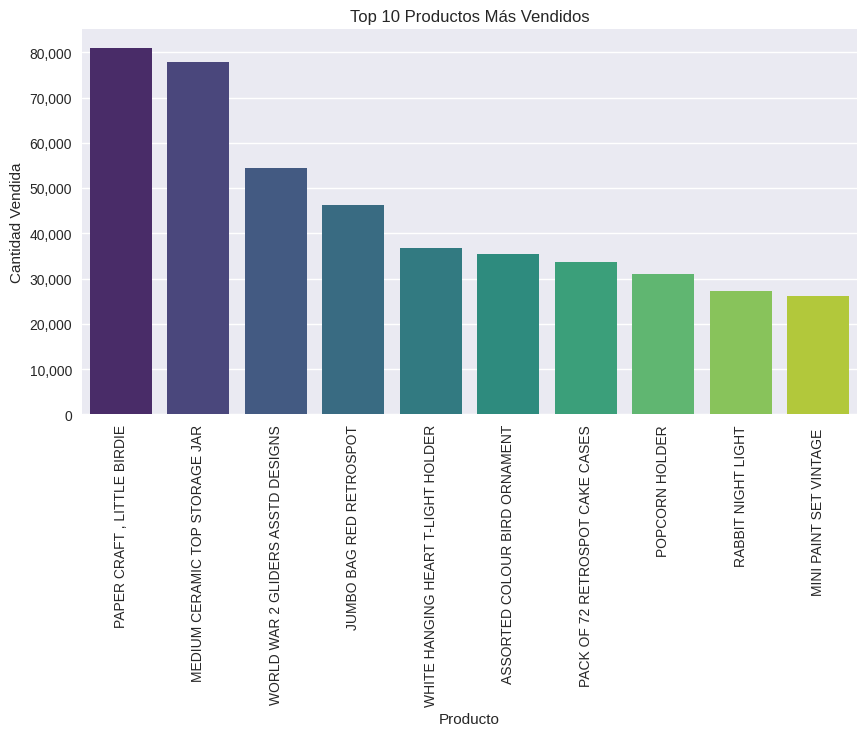

In [ ]:
#------------------------------------------------------------------------
#Gráfico de barras productos mas vendidos - CLientes con ID
#------------------------------------------------------------------------

top_products = df.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
sb = sns.barplot(x=top_products.index.astype(str), y=top_products, hue=top_products.index.astype(str), palette="viridis", legend=False)
sb.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.xticks(rotation=90)
plt.title("Top 10 Productos Más Vendidos")
plt.xlabel("Producto")
plt.ylabel("Cantidad Vendida")
plt.show()

## Df sin clientes
Se muestran los productos mas vendidos de las transacciones que no cuentan con ID de cliente.

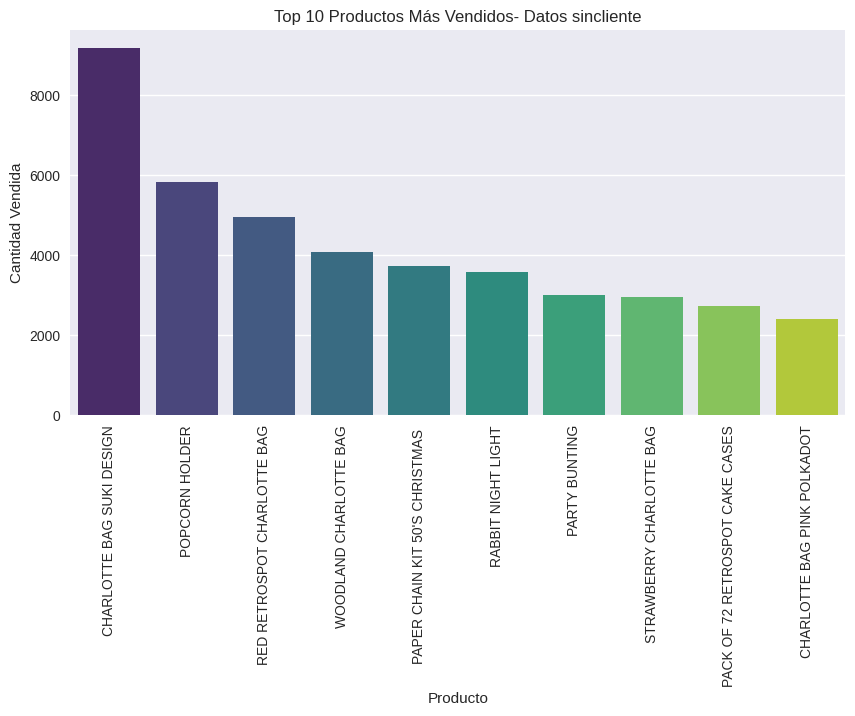

In [ ]:
#------------------------------------------------------------------------
#Grafico de barras de productos mas vendidos sin  ID Cliente
#------------------------------------------------------------------------

noclient_top_products = df_no_client.groupby("Description")["Quantity"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
nc_sb = sns.barplot(x=noclient_top_products.index.astype(str), y=noclient_top_products, hue=noclient_top_products.index.astype(str), palette="viridis", legend=False)
sb.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.xticks(rotation=90)
plt.title("Top 10 Productos Más Vendidos- Datos sincliente")
plt.xlabel("Producto")
plt.ylabel("Cantidad Vendida")
plt.show()

## RFM
A continuación, se realiza la transformación necesaria para el análisis RFM. Es importante tener en cuenta que esta transformación se aplica únicamente a aquellos clientes con un CustomerID en el conjunto de datos, ya que el análisis RFM se basa en la identificación de compras individuales por cliente. En total 4.338 clientes fueron usados para el análisis.

La tabla muestra las estadísticas descriptivas de las métricas RFM (Recency, Frequency y Monetary). En promedio, los clientes realizaron compras aproximadamente cada 91 días, aunque hay una gran variabilidad (hasta 373 días sin comprar). La mayoría de los clientes compraron entre 1 y 5 veces, con una mediana de 2 compras. En cuanto al gasto, el monto promedio es de 285.85 libras esterlinas, pero con una alta dispersión, evidenciada por la diferencia entre el mínimo (0.17) y el máximo (33,332.45), lo que indica la presencia de clientes con patrones de compra muy distintos.

In [ ]:
#------------------------------------------------------------------------
#Creación del RFM
#------------------------------------------------------------------------

# Agregar el país más frecuente para cada CustomerID
rfm = df.groupby("CustomerID").agg(
    Recency=("InvoiceDate", lambda x: (df["InvoiceDate"].max() - x.max()).days),
    Frequency=("InvoiceNo", "nunique"),
    Monetary=("UnitPrice", "sum"),
    Country=("Country", lambda x: x.mode()[0] if not x.mode().empty else "Unknown")
)

# Calcular estadísticas descriptivas
rfm_summary = rfm.drop(columns=["Country"]).describe().reset_index()

# tabla con tabulate
from tabulate import tabulate
tabla = tabulate(rfm_summary, headers="keys", tablefmt="pipe", showindex=False, floatfmt=".2f")

print(tabla)

# Shape del RFM
print("\nForma del dataset RFM:", rfm.shape)




| index   |   Recency |   Frequency |   Monetary |
|:--------|----------:|------------:|-----------:|
| count   |   4338.00 |     4338.00 |    4338.00 |
| mean    |     91.54 |        4.27 |     285.85 |
| std     |    100.01 |        7.70 |     880.64 |
| min     |      0.00 |        1.00 |       0.17 |
| 25%     |     17.00 |        1.00 |      51.73 |
| 50%     |     50.00 |        2.00 |     127.29 |
| 75%     |    141.00 |        5.00 |     294.45 |
| max     |    373.00 |      209.00 |   33332.45 |

Forma del dataset RFM: (4338, 4)


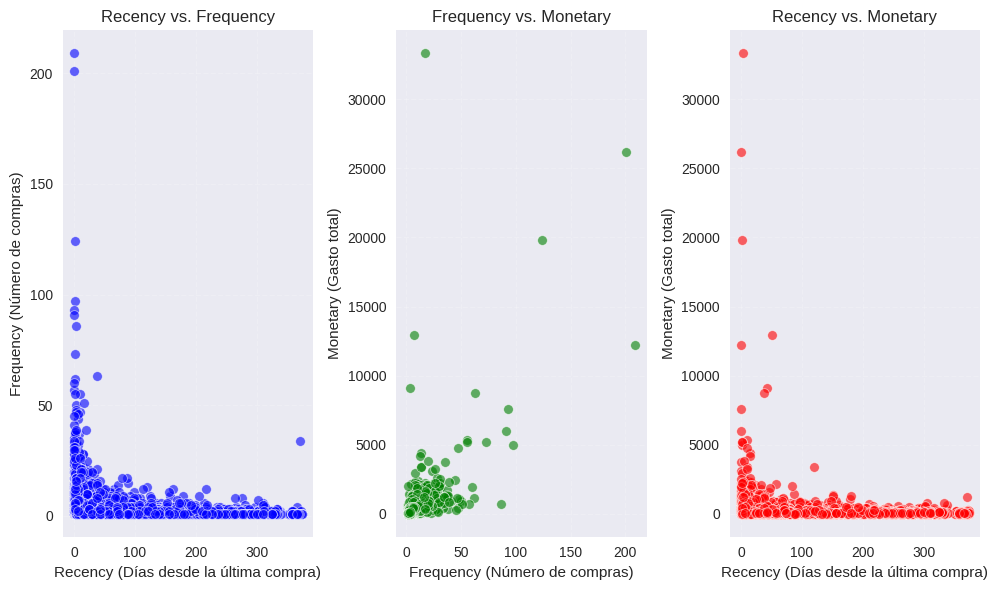

In [ ]:
#------------------------------------------------------------------------
#Gráficos del RFM
#------------------------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Configurar el tamaño de la figura
fig, axes = plt.subplots(1, 3, figsize=(10, 6))

# Recency vs. Frequency
sns.scatterplot(x=rfm["Recency"], y=rfm["Frequency"], ax=axes[0], color="blue", alpha=0.6)
axes[0].set_title("Recency vs. Frequency")
axes[0].set_xlabel("Recency (Días desde la última compra)")
axes[0].set_ylabel("Frequency (Número de compras)")
axes[0].grid(True, linestyle="--", alpha=0.2)

# Monetary vs. Frequency
sns.scatterplot(x=rfm["Frequency"], y=rfm["Monetary"], ax=axes[1], color="green", alpha=0.6)
axes[1].set_title("Frequency vs. Monetary")
axes[1].set_xlabel("Frequency (Número de compras)")
axes[1].set_ylabel("Monetary (Gasto total)")
axes[1].grid(True, linestyle="--", alpha=0.2)

# Recency vs. Monetary
sns.scatterplot(x=rfm["Recency"], y=rfm["Monetary"], ax=axes[2], color="red", alpha=0.6)
axes[2].set_title("Recency vs. Monetary")
axes[2].set_xlabel("Recency (Días desde la última compra)")
axes[2].set_ylabel("Monetary (Gasto total)")
axes[2].grid(True, linestyle="--", alpha=0.2)

plt.tight_layout()
plt.show()


Los gráficos de dispersión permiten analizar la relación entre las métricas RFM (Recencia, Frecuencia y Monetario). En el gráfico de Recencia vs. Frecuencia, se observa que los clientes con baja recencia (es decir, que han comprado recientemente) tienden a tener una mayor frecuencia de compra, lo que sugiere que los clientes más activos realizan compras de manera recurrente. En el gráfico de Frecuencia vs. Monetario, se evidencia que, a medida que aumenta la frecuencia de compra, también incrementa el gasto total del cliente, indicando una correlación positiva entre estas dos variables. Por último, en el gráfico de Recencia vs. Monetario, se aprecia que algunos clientes con un gasto más elevado tienen menos días desde su última compra, lo podría indicar que los clientes que gastan más suelen ser más recientes en sus transacciones.

---
---
# Etapa 2 : Generación del modelos.

In [ ]:
#-----------------------------------------------------------------------
# Normalización de las características RFM (Recency, Frequency, Monetary)
#------------------------------------------------------------------------

from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Copiar el DataFrame original sin la columna 'Country'
rfm_prepared = rfm.drop(columns=['Country']).copy()

# Normalizar las características RFM
scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm_prepared)
rfm_scaled = pd.DataFrame(rfm_scaled, columns=rfm_prepared.columns, index=rfm_prepared.index)

# Mostrar las primeras filas del dataset preparado
print(rfm_scaled.head())

# Mostrar la forma final del dataset
print("\nForma del dataset preparado para K-Means:", rfm_scaled.shape)

             Recency  Frequency  Monetary
CustomerID                               
12346       0.871314   0.000000  0.000026
12347       0.002681   0.028846  0.014432
12348       0.198391   0.014423  0.005356
12349       0.048257   0.000000  0.018148
12350       0.828418   0.000000  0.001954

Forma del dataset preparado para K-Means: (4338, 3)


In [ ]:
rfm.head(5)

,Recency,Frequency,Monetary,Country
CustomerID,,,,
12346,325,1,1.04,United Kingdom
12347,1,7,481.21,Iceland
12348,74,4,178.71,Finland
12349,18,1,605.10,Italy
12350,309,1,65.30,Norway


## k Medias
El algoritmo K-means es una técnica de aprendizaje no supervisado utilizada para agrupar datos en categorías o clusters. Su objetivo es dividir un conjunto de datos en K grupos, asignando cada dato al cluster cuyo centroide (punto medio) esté más cercano. El proceso se lleva a cabo de manera iterativa. En primer lugar, cada punto de datos se asigna al centroide más próximo y, luego, los centroides se recalculan como el promedio de los puntos asignados a cada cluster. Este procedimiento se repite hasta que los centroides se estabilizan o se alcanza un número máximo de iteraciones. [2]

Presenta ciertas limitaciones como la definición de la cantidad de clusters, y que sus resultados dependen de la iniciación de los clusters. Para abordar estos problemas, se utilizan estrategias como el método del codo para determinar el número óptimo de clusters y la ejecución del algoritmo varias veces con diferentes inicializaciones para mejorar la estabilidad de los resultados.

## Método del codo para la definición de K

El método del codo es una técnica gráfica utilizada para determinar el número óptimo de clústeres (K) en algoritmos como K-means. Funciona trazando la inercia (la suma de las distancias cuadradas de los puntos a sus centroides) en función del número de clústeres. A medida que aumenta K, la inercia disminuye, pero llega un punto donde la disminución se ralentiza, formando una curva que similar a un "codo", indicando el punto óptimo de clúesteres, ya que adicionar más no reduce manera significativa la inercia.

En este caso se aprecia que la cantidad aproximada se encuentra en K=3


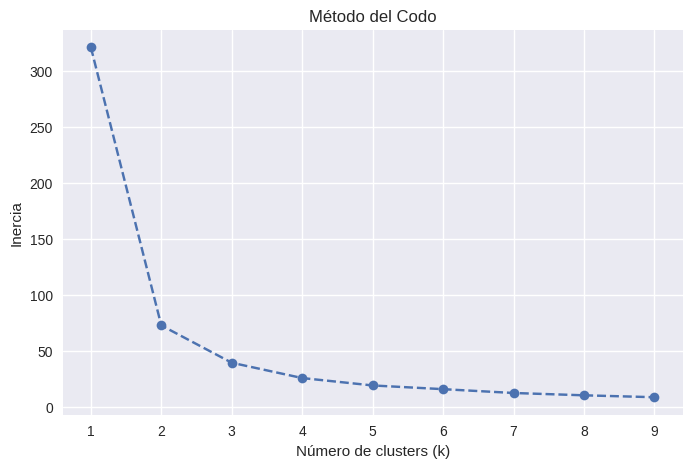

In [ ]:
#-------------------------
#Gráfico del método del codo.
#-------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Probar diferentes valores de k
inertia = []
k_values = range(1, 10)  # De 2 a 10 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Gráfica del método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del Codo")
plt.show()


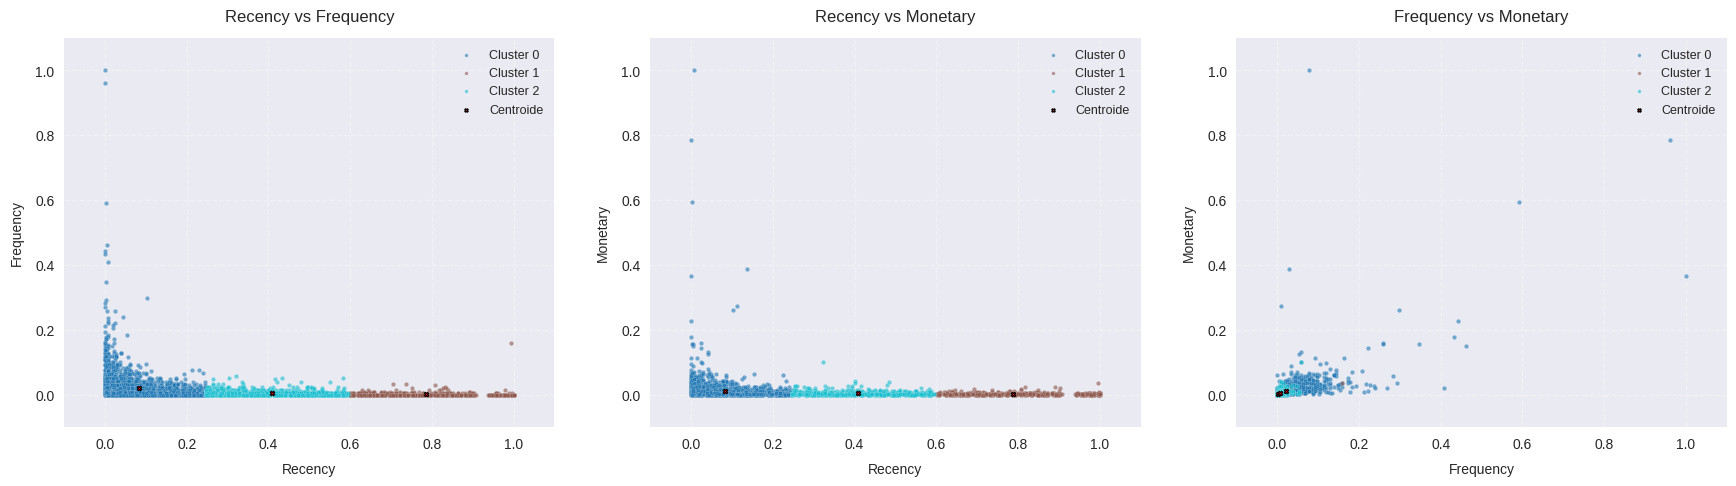

In [ ]:
#--------------------------
# Gráficos de cada clúster
#-------------------------
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np

# Estilo del gráfico
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.facecolor'] = 'white'

# --- Configuración de tamaños ---
POINT_SIZE = 10          # Tamaño de los puntos normales
CENTROID_SIZE = 10       # Tamaño de los centroides
POINT_ALPHA = 0.6        # Transparencia de los puntos
POINT_EDGE_WIDTH = 0.15  # Grosor del borde de los puntos

# Eliminar columna 'Cluster' en caso de querer volver a ejecutar todo el codigo y no se elimina el entorno.
if "Cluster" in rfm_scaled.columns:
    rfm_scaled = rfm_scaled.drop(columns=["Cluster"])

# Configurar y aplicar K-Means
k = 3  # clusters
kmeans = KMeans(n_clusters=k, init="k-means++", tol=1e-4, max_iter=300, random_state=42)
rfm_scaled["Cluster"] = kmeans.fit_predict(rfm_scaled)

# Obtener centroides
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=rfm_scaled.columns[:-1])

# Preparar visualización
features = rfm_scaled.columns[:-1]
combinations = list(itertools.combinations(features, 2))
n_plots = len(combinations)
n_cols = min(3, n_plots)
n_rows = (n_plots + n_cols - 1) // n_cols

# Crear figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5.5*n_rows))
if n_plots == 1:
    axes = np.array([axes])
axes = axes.flatten()

# Paleta de colores
colors = plt.cm.tab10(np.linspace(0, 1, k))

for i, (x_col, y_col) in enumerate(combinations):
    ax = axes[i]

    # Graficar cada cluster
    for cluster in range(k):
        cluster_data = rfm_scaled[rfm_scaled["Cluster"] == cluster]
        ax.scatter(
            cluster_data[x_col],
            cluster_data[y_col],
            color=colors[cluster],
            alpha=POINT_ALPHA,
            s=POINT_SIZE,
            edgecolor='w',
            linewidth=POINT_EDGE_WIDTH,
            label=f'Cluster {cluster}' )

    # Graficar centroides
    ax.scatter(
        centroids[x_col],
        centroids[y_col],
        c='red',
        marker='X',
        s=CENTROID_SIZE,
        label='Centroide',
        edgecolor='k',
        linewidth=0.8)

    # Ajustes de ejes
    ax.set_xlabel(x_col, fontsize=10, labelpad=8)
    ax.set_ylabel(y_col, fontsize=10, labelpad=8)
    ax.set_title(f"{x_col} vs {y_col}", fontsize=12, pad=12)
    ax.grid(True, linestyle='--', alpha=0.3)

    # Leyenda simplificada
    ax.legend(
        fontsize=9,
        framealpha=0.9,
        markerscale=0.8,
        loc='upper right')

    # Ajustar límites
    x_buffer = (rfm_scaled[x_col].max() - rfm_scaled[x_col].min()) * 0.1
    y_buffer = (rfm_scaled[y_col].max() - rfm_scaled[y_col].min()) * 0.1
    ax.set_xlim([rfm_scaled[x_col].min() - x_buffer, rfm_scaled[x_col].max() + x_buffer])
    ax.set_ylim([rfm_scaled[y_col].min() - y_buffer, rfm_scaled[y_col].max() + y_buffer])

# Quitar vacios
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=3.0)
plt.show()

## Parámetros de K-Means
A continuación se listan los parámetros usados en la construcción de este modelo.




| Parámetro        | Valor         | Descripción |
|-----------------|--------------|-------------|
| `n_clusters`    | `3`          | Especifica el número de clusters en los que se agruparán los datos. En este caso, se crean tres grupos conforme al método del codo |
| `init`         | `"k-means++"` | Método de inicialización de los centroides para mejorar la eficiencia y la convergencia del algoritmo. |
| `tol`          | `1e-4`        | Define el umbral de tolerancia para la convergencia. Si los centroides cambian menos que `0.0001`, el algoritmo se detiene. |
| `max_iter`     | `300`        | Iteraciones máximas del algoritmo antes de detenerse. Si no converge, se detiene en la iteración 300. |
| `random_state` | `42`         | Fija la semilla aleatoria para garantizar que los resultados sean reproducibles en distintas ejecuciones. |



---
**Clusters - Recency vs Frequency**

Esta gráfica muestra la segmentación de clientes basada en la recencia  y la frecuencia. Se identifican tres clústeres principales: uno con baja recencia y baja frecuencia (clientes inactivos o poco frecuentes), otro con recencia moderada y baja frecuencia (clientes ocasionales), y un tercero con alta recencia y baja frecuencia (clientes que interactuaron recientemente pero no son frecuentes).

**Clusters - Recency vs Monetary**

Aquí se segmenta a los clientes según la recencia y el valor monetario gastado. Se observan clústeres que representan clientes de bajo valor y baja recencia, clientes de valor moderado y baja recencia, y clientes de alta recencia pero bajo valor.

**Clusters - Frequency vs Monetary**

Se identifican grupos de clientes con diferentes combinaciones de frecuencia y gasto. Se observa un clúster de clientes con baja frecuencia y bajo gasto, otro con frecuencia y gasto moderados, y algunos clientes con alta frecuencia pero bajo gasto.

## Evaluación del modelo.

A continuación se presentan las distintas métricas para evaluar los resultados optenidos del método de K-Medias para


Métricas globales de clustering:
|                 Métrica |      Valor |
|------------------------:|-----------:|
|        Silhouette Score |     0.6458 |
|    Davies-Bouldin Index |     0.5043 |
| Calinski-Harabasz Index | 15465.7    |

Análisis por cluster:

Cluster 0:
|:--------------------|:-------|
| Tamaño              | 2906   |
| % del total         | 67.0%  |
| Distancia centroide | 0.0666 |

  Medias y medianas:
| Variable   |   Media |   Mediana |
|:-----------|--------:|----------:|
| Recency    |  0.0835 |    0.0643 |
| Frequency  |  0.0215 |    0.0096 |
| Monetary   |  0.0111 |    0.0054 |

  Desviaciones estándar:
| Variable   |   Desviación Estándar |
|:-----------|----------------------:|
| Recency    |                0.0673 |
| Frequency  |                0.0437 |
| Monetary   |                0.0318 |

Cluster 1:
|:--------------------|:-------|
| Tamaño              | 626    |
| % del total         | 14.4%  |
| Distancia centroide | 0.1042 |

  Medias y medianas:


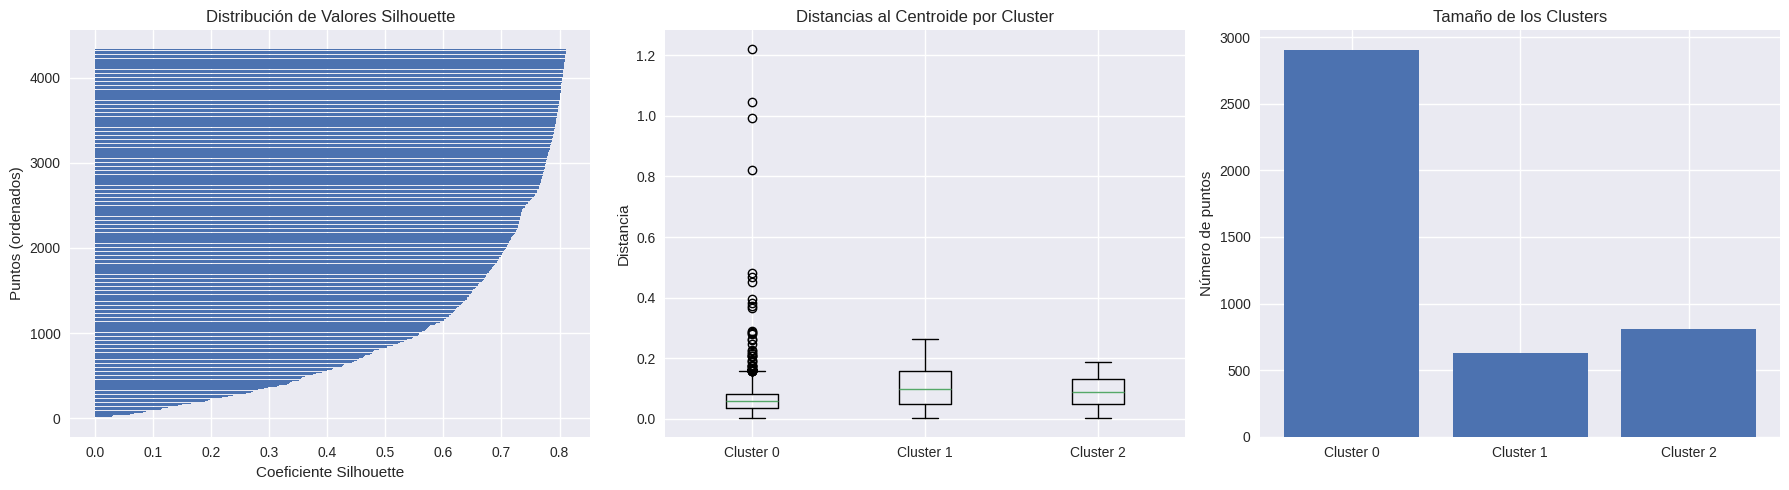

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def evaluate_clusters(data, labels):
    """
    Evalúa la calidad de los clusters utilizando múltiples métricas
    """
    metrics = {
        'Silhouette Score': silhouette_score(data, labels),
        'Davies-Bouldin Index': davies_bouldin_score(data, labels),
        'Calinski-Harabasz Index': calinski_harabasz_score(data, labels)}
    return metrics

# Calcular métricas para todos los clusters
global_metrics = evaluate_clusters(rfm_scaled.drop(columns=['Cluster']), rfm_scaled['Cluster'])

# Mostrar métricas globales
print("\nMétricas globales de clustering:")
metrics_table = [[k, f"{v:.4f}"] for k, v in global_metrics.items()]
print(tabulate(metrics_table, headers=["Métrica", "Valor"], tablefmt="pipe", stralign="right"))

# Función para analizar cada cluster
def analyze_clusters(data, centroids, cluster_col='Cluster'):
    """
    Analiza las características de cada cluster individual
    """
    cluster_stats = {}

    for cluster in sorted(data[cluster_col].unique()):
        cluster_data = data[data[cluster_col] == cluster].drop(columns=[cluster_col])

        stats = {
            'Tamaño': len(cluster_data),
            '% del total': len(cluster_data)/len(data),
            'Distancia al Centroide': np.mean(np.sqrt(np.sum((cluster_data - centroids.loc[cluster])**2, axis=1))),
            'Media': cluster_data.mean().to_dict(),
            'Mediana': cluster_data.median().to_dict(),
            'Desviación Estándar': cluster_data.std().to_dict()
        }
        cluster_stats[f'Cluster {cluster}'] = stats

    return cluster_stats

# Analizar cada cluster
cluster_analysis = analyze_clusters(rfm_scaled, centroids)

# Mostrar análisis por cluster con tablas formateadas
print("\nAnálisis por cluster:")
for cluster, stats in cluster_analysis.items():
    # Tabla de estadísticas
    basic_stats = [
        ["Tamaño", stats['Tamaño']],
        ["% del total", f"{stats['% del total']:.1%}"],
        ["Distancia centroide", f"{stats['Distancia al Centroide']:.4f}"]
    ]
    print(f"\n{cluster}:")
    print(tabulate(basic_stats, tablefmt="pipe", floatfmt=".4f"))

    # Tabla de medias y medianas
    variables = list(stats['Media'].keys())
    mean_median_table = [
        [var, f"{stats['Media'][var]:.4f}", f"{stats['Mediana'][var]:.4f}"]
        for var in variables
    ]
    print("\n  Medias y medianas:")
    print(tabulate(mean_median_table, headers=["Variable", "Media", "Mediana"], tablefmt="pipe", floatfmt=".4f"))

    # Tabla de desviaciones estándar
    std_table = [
        [var, f"{stats['Desviación Estándar'][var]:.4f}"]
        for var in variables
    ]
    print("\n  Desviaciones estándar:")
    print(tabulate(std_table, headers=["Variable", "Desviación Estándar"], tablefmt="pipe", floatfmt=".4f"))

# Visualización de métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico de Silhouette
silhouette_vals = silhouette_samples(rfm_scaled.drop(columns=['Cluster']), rfm_scaled['Cluster'])
axes[0].barh(range(len(silhouette_vals)), np.sort(silhouette_vals))
axes[0].set_title('Distribución de Valores Silhouette')
axes[0].set_xlabel('Coeficiente Silhouette')
axes[0].set_ylabel('Puntos (ordenados)')

# Gráfico de distancias al centroide
distances = []
cluster_labels = []
for cluster in sorted(rfm_scaled['Cluster'].unique()):
    cluster_data = rfm_scaled[rfm_scaled['Cluster'] == cluster].drop(columns=['Cluster'])
    dist = np.sqrt(np.sum((cluster_data - centroids.loc[cluster])**2, axis=1))
    distances.append(dist)
    cluster_labels.append(f'Cluster {cluster}')

boxplot = axes[1].boxplot(distances)
axes[1].set_xticklabels(cluster_labels)
axes[1].set_title('Distancias al Centroide por Cluster')
axes[1].set_ylabel('Distancia')

# Gráfico de tamaño de clusters
sizes = [len(rfm_scaled[rfm_scaled['Cluster'] == c]) for c in sorted(rfm_scaled['Cluster'].unique())]
axes[2].bar([f'Cluster {i}' for i in range(len(sizes))], sizes)
axes[2].set_title('Tamaño de los Clusters')
axes[2].set_ylabel('Número de puntos')

plt.tight_layout()
plt.show()


## Análisis de los resultados del modelo.

A continuación se presentan los resultados de las métricas relevantes para evaluar la calidad de los clústers generados mediante el algoritmo de k-means.

---
**Métricas globales del modelo**

**Silhouette Score: 0.6458**

Un Silhouette Score de 0.6458 es considerado bueno. Indica que los clústeres están bien definidos y separados, lo que sugiere una buena calidad de la segmentación.[3]

**Davies-Bouldin Index: 0.5043**

El Davies-Bouldin Index mide la similitud promedio de cada clúster con su clúster más similar, donde la similitud se define como la relación entre la dispersión dentro del clúster y la separación entre clústeres. Un Davies-Bouldin Index de 0.5043 es relativamente bajo, lo que indica una buena separación entre los clústeres y una baja dispersión dentro de los clústeres. [4]

**Calinski-Harabasz Index: 15465.6686**

El Calinski-Harabasz Index mide la relación entre la dispersión entre clústeres y la dispersión dentro de los clústeres. Un valor más alto indica una mejor segmentación.Un Calinski-Harabasz Index de 15465.6686 es muy alto, lo que indica una excelente separación entre los clústeres y una baja dispersión dentro de los clústeres. Esto refuerza la conclusión de que la segmentación es de alta calidad. [5]

---

**Análisis de cada clúster.**

* **Cluster 0:** Este clúster es el más grande, representando el 67% de los datos, y se caracteriza por clientes que han interactuado recientemente (baja recencia) pero con baja frecuencia y bajo gasto. La baja distancia al centroide indica que los puntos están muy agrupados, sugiriendo un grupo homogéneo. Las medianas inferiores a las medias en las variables "Recency", "Frequency" y "Monetary" indican que la distribución de los datos está sesgada hacia la derecha. Este grupo podría representar a clientes nuevos o aquellos que realizan compras pequeñas regularmente.

* **Cluster 1:** Este clúster es el más pequeño, con solo el 14.4% de los datos, y representa a clientes inactivos o con interacciones muy espaciadas. La alta distancia al centroide indica una mayor dispersión de los puntos. Las medianas son inferiores a las medias, lo cual indica que la distribución de los datos esta sesgada a la derecha. La alta recencia y la muy baja frecuencia y gasto sugieren que estos clientes han perdido interés o tienen un bajo compromiso con la empresa.

* **Cluster 2:** Este clúster representa el 18.6% de los datos y muestra un grupo intermedio de clientes. Tienen una recencia moderada, lo que indica que han interactuado recientemente, pero aún con baja frecuencia y gasto. La distancia al centroide es moderada, lo que sugiere una dispersión moderada de los puntos. Las medianas son inferiores a las medias, lo cual indica que la distribución de los datos esta sesgada a la derecha.

---

**Gráfico 1: Distribución de Valores Silhouette**
Se muestra la distribución de los coeficientes de Silhouette para cada punto de datos en la segmentación. Los coeficientes de Silhouette miden qué tan similar es un punto a su propio clúster (cohesión) en comparación con otros clústeres (separación).

La mayoría de las barras tienen longitudes mayores a 0.5 indicando que la segmentación realizada tiene buena calidad.


**Gráfico 2: Distancias al Centroide por Cluster**

Este gráfico muestra la distribución de las distancias de los puntos de datos al centroide de su respectivo clúster para cada clúster.

Los tres clústeres muestran distribuciones de distancias similares, con la mayoría de los puntos cercanos a los centroides y algunos valores atípicos (outliers) con distancias mayores.

**Gráfico 3: Tamaño de los Clústeres**

El Clúster 0 tiene un tamaño significativamente mayor que los Clústeres 1 y 2, mostrando una diferencia en la densidad de cada clúster

---
---
# Etapa 3 : Conclusiones y recomendaciones.

A continuación se presentan las carácteristicas principales de cada clúster, las recomendaciones y conclusiones.

In [ ]:

# ---------------------------------------------------
# Valores del dataframe RFM Original
# ---------------------------------------------------

# Añadir la columna 'Cluster' al DataFrame original
rfm['Cluster'] = rfm_scaled['Cluster']

# Agrupar por cluster y calcular estadísticas descriptivas
cluster_stats_original = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'std'],
    'Frequency': ['mean', 'median', 'std'],
    'Monetary': ['mean', 'median', 'std']
})

# Transponer la tabla y mejorar la presentación
cluster_stats_transposed = cluster_stats_original.T
cluster_stats_transposed.index = [f"{var} - {stat}" for var, stat in cluster_stats_transposed.index]

# Convertir el índice en una columna para mejor presentación
cluster_stats_transposed = cluster_stats_transposed.reset_index().rename(columns={'index': 'Métrica'})

# Redondear los valores para una mejor visualización
cluster_stats_transposed = cluster_stats_transposed.round(2)

# Mostrar resultados con formato profesional
from tabulate import tabulate
print(tabulate(cluster_stats_transposed, headers='keys', tablefmt='pipe', showindex=False))



| Métrica            |       0 |      1 |      2 |
|:-------------------|--------:|-------:|-------:|
| Recency - mean     |   31.16 | 293.43 | 152.4  |
| Recency - median   |   24    | 286.5  | 151.5  |
| Recency - std      |   25.09 |  45.11 |  38.41 |
| Frequency - mean   |    5.47 |   1.35 |   2.22 |
| Frequency - median |    3    |   1    |   2    |
| Frequency - std    |    9.1  |   1.53 |   1.65 |
| Monetary - mean    |  370.17 |  83.39 | 139.06 |
| Monetary - median  |  180.26 |  57.05 |  85.79 |
| Monetary - std     | 1059.49 | 102.04 | 200.43 |


## Recomendaciones por cada clúster
**Cluster 0: Clientes Valiosos (67%)**
Clientes frecuentes (5.5 compras en promedio), con alta rentabilidad (£370 de gasto promedio) y actividad reciente (última compra aproximadamente 1 mes).

Estrategia:
- Implementar un programa con beneficios exclusivos (envíos gratis, acceso prioritario).
- Upselling de productos premium (estrategia que consiste en que el cliente compre mejores versiones de un producto o servicio) basado en su historial.
- Bundles de productos complementarios para aumentar las compras promedio.

**Cluster 1: Clientes Inactivos (14.4%)**
Sin compras en  los últimos 10 meses, bajo gasto histórico (£83 promedio) y poca frecuencia (1.3 compras en promedio).

Estrategia:
- Campaña de reactivación con descuentos.
- Encuesta de satisfacción para identificar motivos de abandono.
- Evaluar costo-beneficio para decidir si mantenerlos o descartarlos.

**Cluster 2: Clientes Ocasionales (18.6%)**
Compran alrededor de  cada 5 meses (gasto promedio: £139) con potencial no explotado (2.2 compras en promedio).

Estrategia:
- Programa de fidelización por frecuencia.
- Cross-selling (Estrategia en la que se busca acompañar una venta inicial con una venta complementaria) con productos relacionados a sus compras pasadas.
- Ofertas personalizadas.

Finalmente, seria realmente útil, por ejemplo, categorizar los productos en grupos más amplios (por ejemplo, productos de limpieza, granos, carnes, etc.), con la intención de que las ofertas especializadas o la búsqueda de productos complementarios sea más sencilla. También, sería útil tener información sobre las variaciones de los precios de los productos, por ejemplo, con la intención de predecir que tan sensibles al precio son los compradores de cada uno de los clúseteres. O incluso, determinar si hay clientes que solo compran X productos cuando estos se encuentran en descuento.

---
# Referencias:

[1]J. T. Wei, S. Y. Lin, y H. H. Wu, "A review of the application of RFM model," African Journal of Business Management, vol. 4, no. 19, pp. 4199–4206, 2010.

[2] P.-N. Tan, M. Steinbach, y V. Kumar, Introduction to Data Mining, 2nd ed. Pearson, 2018, ch. 8

[3] P. J. Rousseeuw, "Silhouettes: A graphical aid to the interpretation and validation of cluster analysis," *J. Comput. Appl. Math.*, vol. 20, pp. 53–65, Nov. 1987, doi: 10.1016/0377-0427(87)90125-7.

[4] D. L. Davies and D. W. Bouldin, "A cluster separation measure," *IEEE Trans. Pattern Anal. Mach. Intell.*, vol. PAMI-1, no. 2, pp. 224–227, Apr. 1979, doi: 10.1109/TPAMI.1979.4766909.

[5] T. Caliński and J. Harabasz, "A dendrite method for cluster analysis," *Commun. Stat.*, vol. 3, no. 1, pp. 1–27, Jan. 1974, doi: 10.1080/03610927408827101.

